In [4]:
import itertools
import pandas as pd 
import numpy as np 

from time import time 
from matplotlib import pyplot as plt 
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, scale 
import seaborn as sns
from sklearn.learning_curve import learning_curve

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


In [5]:
%matplotlib inline

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5), n_jobs=-1):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)
    return estimator

In [7]:
df = pd.read_csv('./LC.csv', index_col=0)

In [8]:
df.groupby('status_num').size()

status_num
-1    679563
 0    327948
 1    108921
dtype: int64

In [9]:
df.drop('emp_length', axis=1, inplace=True)  # many nans

In [10]:
# df.head(5)

In [11]:
df2 = df[df['status_num'] >= 0]

In [12]:
df2.dropna(inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
df2.groupby('status_num').size() 

status_num
0    327731
1    108836
dtype: int64

In [14]:
features_cat=['grade','home_ownership','verification_status']
#features_cat=['grade','home_ownership','verification_status','purpose','addr_state','initial_list_status']
features_num=['term','int_rate','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc','pub_rec','total_acc', 'revol_util'] #'emp_length' 


In [15]:
X_categorical = pd.get_dummies(df2[features_cat])
df2 = pd.concat([df2.drop(features_cat, axis=1), X_categorical], axis=1)


In [16]:
X_unscaled = df2[features_num + X_categorical.columns.tolist()]
X = scale(X_unscaled.values)
y = df2['status_num'].values

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure() 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [18]:
def classify(X_, y_):
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.3)
    # y_test[y_test==1].shape , y_train[y_train==1].shape 
    clf = RandomForestClassifier(class_weight={1:1}, n_jobs=-1, criterion='entropy')
    clf.fit(X_train, y_train)
    
    p = clf.predict(X_test)
    cf_matrix = confusion_matrix(y_test, p)
    print cf_matrix
    
    plot_confusion_matrix(cf_matrix, classes=clf.classes_)
    print classification_report(y_test, p
                            , target_names=['non-defaulted','defaulted'])
    
    pp = clf.predict_proba(X_test)
    
    return clf, p, pp, y_test

[[92004  6332]
 [27252  5383]]
Confusion matrix, without normalization
[[92004  6332]
 [27252  5383]]


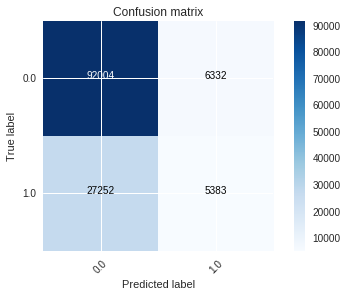

               precision    recall  f1-score   support

non-defaulted       0.77      0.94      0.85     98336
    defaulted       0.46      0.16      0.24     32635

  avg / total       0.69      0.74      0.70    130971



In [31]:
clf, p, pp, y_test = classify(X, y)

In [33]:
for i in zip(clf.feature_importances_, X_unscaled.columns):
    print i 

(0.014956982883695865, 'term')
(0.13311807494817179, 'int_rate')
(0.16636150943811395, 'dti')
(0.023940978327145684, 'delinq_2yrs')
(0.15386438940538982, 'earliest_cr_line')
(0.043984290483189518, 'inq_last_6mths')
(0.099937193393547868, 'open_acc')
(0.019161141143137696, 'pub_rec')
(0.1194940128250005, 'total_acc')
(0.15442635185134218, 'revol_util')
(0.012315702565196261, 'grade_A')
(0.0062142195301322003, 'grade_B')
(0.0045171081284405747, 'grade_C')
(0.0033772552709910044, 'grade_D')
(0.0060936673385996575, 'grade_E')
(0.0035756797118278302, 'grade_F')
(0.00068569744863444782, 'grade_G')
(6.685476289796455e-07, 'home_ownership_ANY')
(0.0053435779041667072, 'home_ownership_MORTGAGE')
(5.824585381475928e-05, 'home_ownership_NONE')
(6.5035637879699517e-05, 'home_ownership_OTHER')
(0.0042975326854199922, 'home_ownership_OWN')
(0.0053954876103719006, 'home_ownership_RENT')
(0.006590131857209666, 'verification_status_Not Verified')
(0.0058001544899481967, 'verification_status_Source Veri

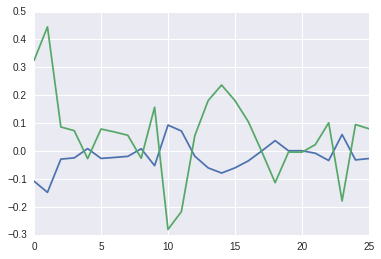

In [20]:
for i in [0, 1]:
    plt.plot(X[y==i].mean(axis=0), label=i)

In [21]:
from sklearn.decomposition import PCA

In [22]:
pca = PCA() 
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [23]:
for i in  zip(pca.explained_variance_, pca.explained_variance_ratio_):
    print i 

(2.8049468995305302, 0.1078825730588667)
(2.3903730479971235, 0.091937424922966415)
(1.5350227036710713, 0.059039334756579749)
(1.4729527323311873, 0.056652028166584205)
(1.3597105527600011, 0.052296559721538571)
(1.3209800002044991, 0.0508069230847885)
(1.2954901490899622, 0.049826544195767847)
(1.1871009149026945, 0.045657727496257544)
(1.176927157598282, 0.045266429138395528)
(1.1104918128301446, 0.042711223570390235)
(1.059991950286221, 0.040768921164854706)
(1.0147453391800061, 0.039028666891538749)
(1.0032621723336976, 0.038587006628219192)
(1.0009462557237543, 0.03849793291245214)
(0.99990459690095013, 0.03845786911157506)
(0.99727451438197456, 0.03835671209161446)
(0.96682175046519858, 0.037185451940969227)
(0.9213130475114919, 0.035435117211980505)
(0.81867408499365468, 0.031487464807448302)
(0.7276754989766141, 0.027987519191408274)
(0.49721762151813981, 0.019123754673774633)
(0.29136893472395464, 0.011206497489382886)
(0.046808262088811531, 0.0018003177726465998)
(1.71258443

----- n_components 2 ----
[[91792  6592]
 [27371  5216]]
Confusion matrix, without normalization
[[91792  6592]
 [27371  5216]]


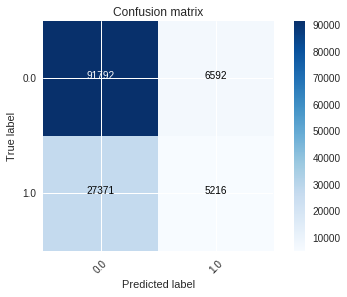

               precision    recall  f1-score   support

non-defaulted       0.77      0.93      0.84     98384
    defaulted       0.44      0.16      0.23     32587

  avg / total       0.69      0.74      0.69    130971

----- n_components 5 ----
[[91709  6402]
 [27648  5212]]
Confusion matrix, without normalization
[[91709  6402]
 [27648  5212]]


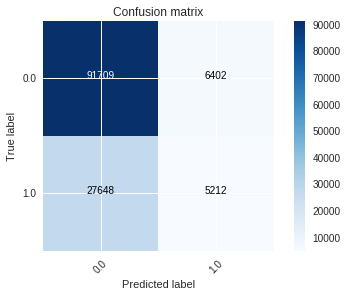

               precision    recall  f1-score   support

non-defaulted       0.77      0.93      0.84     98111
    defaulted       0.45      0.16      0.23     32860

  avg / total       0.69      0.74      0.69    130971

----- n_components 8 ----
[[91950  6443]
 [27370  5208]]
Confusion matrix, without normalization
[[91950  6443]
 [27370  5208]]


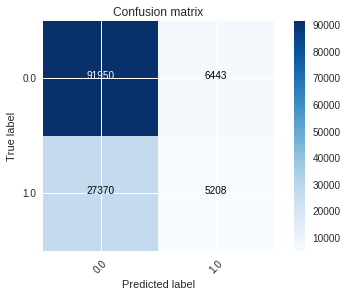

               precision    recall  f1-score   support

non-defaulted       0.77      0.93      0.84     98393
    defaulted       0.45      0.16      0.24     32578

  avg / total       0.69      0.74      0.69    130971

----- n_components 11 ----
[[91822  6330]
 [27685  5134]]
Confusion matrix, without normalization
[[91822  6330]
 [27685  5134]]


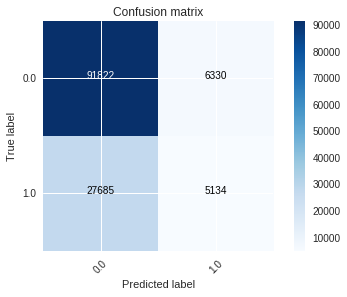

               precision    recall  f1-score   support

non-defaulted       0.77      0.94      0.84     98152
    defaulted       0.45      0.16      0.23     32819

  avg / total       0.69      0.74      0.69    130971

----- n_components 14 ----
[[92062  6465]
 [27302  5142]]
Confusion matrix, without normalization
[[92062  6465]
 [27302  5142]]


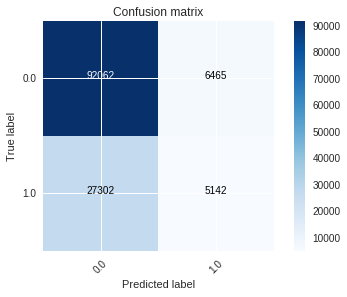

               precision    recall  f1-score   support

non-defaulted       0.77      0.93      0.85     98527
    defaulted       0.44      0.16      0.23     32444

  avg / total       0.69      0.74      0.69    130971

----- n_components 17 ----
[[91958  6262]
 [27633  5118]]
Confusion matrix, without normalization
[[91958  6262]
 [27633  5118]]


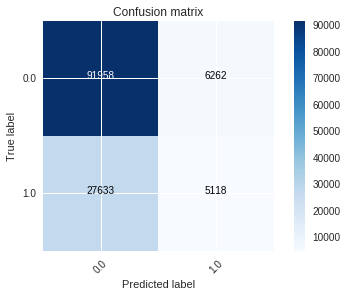

               precision    recall  f1-score   support

non-defaulted       0.77      0.94      0.84     98220
    defaulted       0.45      0.16      0.23     32751

  avg / total       0.69      0.74      0.69    130971

----- n_components 20 ----
[[91919  6719]
 [27194  5139]]
Confusion matrix, without normalization
[[91919  6719]
 [27194  5139]]


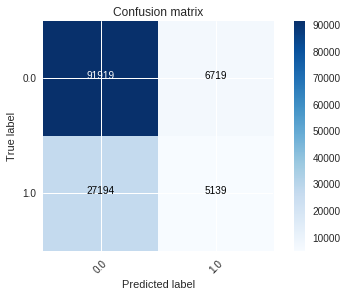

               precision    recall  f1-score   support

non-defaulted       0.77      0.93      0.84     98638
    defaulted       0.43      0.16      0.23     32333

  avg / total       0.69      0.74      0.69    130971

----- n_components 23 ----
[[91966  6375]
 [27419  5211]]
Confusion matrix, without normalization
[[91966  6375]
 [27419  5211]]


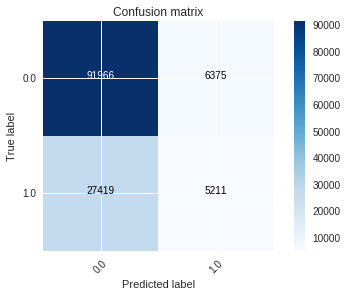

               precision    recall  f1-score   support

non-defaulted       0.77      0.94      0.84     98341
    defaulted       0.45      0.16      0.24     32630

  avg / total       0.69      0.74      0.69    130971

----- n_components 26 ----
[[91787  6630]
 [27190  5364]]
Confusion matrix, without normalization
[[91787  6630]
 [27190  5364]]


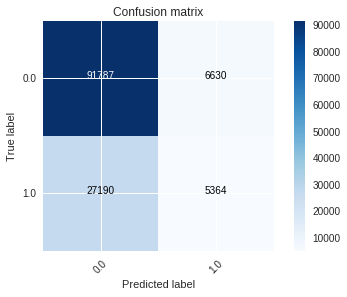

               precision    recall  f1-score   support

non-defaulted       0.77      0.93      0.84     98417
    defaulted       0.45      0.16      0.24     32554

  avg / total       0.69      0.74      0.69    130971



In [24]:
n_components_array = range(2, X.shape[1]+1, 3)
for n_components in n_components_array:
    print '-' * 5, 'n_components', n_components, '-' * 4
    X_reduced = pca.fit_transform(X)
    classify(X_reduced, y)
#     X_reduced.shape 

### Clustering 

In [28]:
# labels = y_train
# sample_size = 300
# def bench_k_means(estimator, name, data):
#     t0 = time()
#     estimator.fit(data)
#     print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
#           % (name, (time() - t0), estimator.inertia_,
#              metrics.homogeneity_score(labels, estimator.labels_),
#              metrics.completeness_score(labels, estimator.labels_),
#              metrics.v_measure_score(labels, estimator.labels_),
#              metrics.adjusted_rand_score(labels, estimator.labels_),
#              metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
#              metrics.silhouette_score(data, estimator.labels_,
#                                       metric='euclidean',
#                                       sample_size=sample_size)))
#     return estimator

In [29]:

# kmeans2 = bench_k_means(KMeans(init='k-means++', n_clusters=2, n_init=10),
#               name="k-means++", data=X_train)

In [30]:
# p_kmeans = kmeans2.predict(X_test)

In [231]:
print classification_report(y_test, p_kmeans)

             precision    recall  f1-score   support

        0.0       0.75      0.56      0.64     98168
        1.0       0.25      0.44      0.32     32803

avg / total       0.63      0.53      0.56    130971



In [247]:
# _ = sns.pairplot(df2[:50], hue='status_num', size=1.5)

In [27]:
# plt.figure(figsize=(12, 10))
# _ = sns.corrplot(df2, annot=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

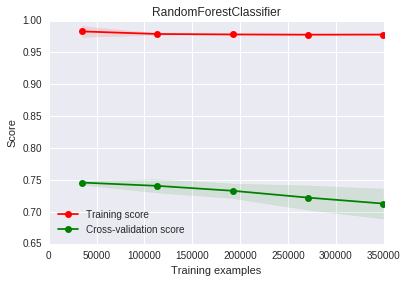

In [26]:
plot_learning_curve(RandomForestClassifier(), 'RandomForestClassifier', 
                    X, y)

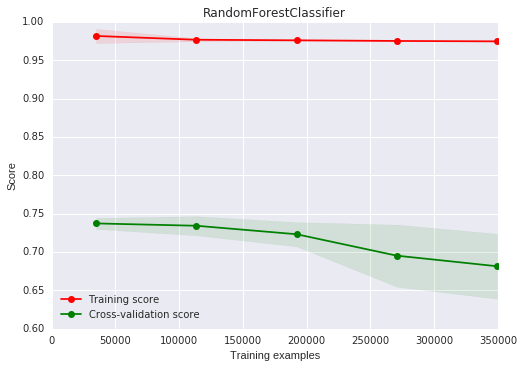

In [252]:
plot_learning_curve(
    RandomForestClassifier(), 
    'RandomForestClassifier', 
    X[:, :5], 
    y)

Pipeline(steps=[('fs', SelectKBest(k='all', score_func=<function f_classif at 0x7ff1c4d58c80>)), ('RandomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

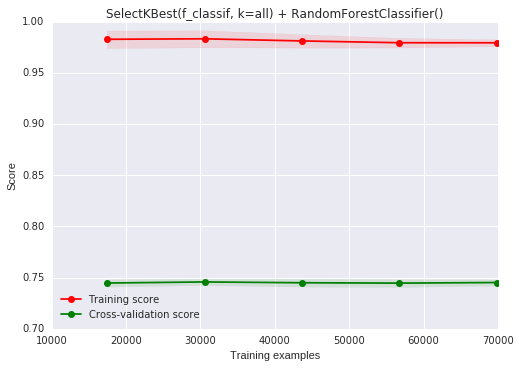

In [277]:
plot_learning_curve(
    Pipeline([("fs", SelectKBest(f_classif, k='all')), 
             ('RandomForest', RandomForestClassifier())]),
    "SelectKBest(f_classif, k=all) + RandomForestClassifier()",
    X,y,
#     train_sizes=np.linspace(.05, 0.2, 5)
)

Pipeline(steps=[('fs', SelectKBest(k=10, score_func=<function f_classif at 0x7ff1c4d58c80>)), ('RandomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

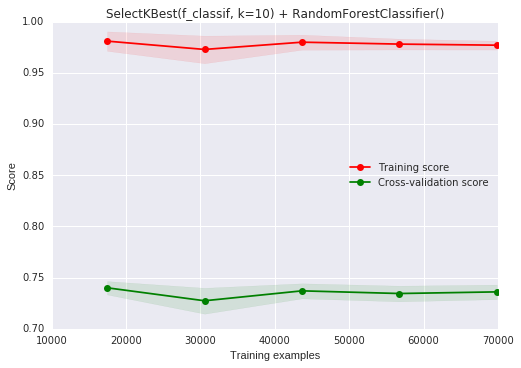

In [279]:
plot_learning_curve(
    Pipeline([("fs", SelectKBest(f_classif, k=10)), 
             ('RandomForest', RandomForestClassifier())]),
    "SelectKBest(f_classif, k=10) + RandomForestClassifier()",
    X,y,
    train_sizes=np.linspace(.05, 0.2, 5)
)

Pipeline(steps=[('fs', SelectKBest(k=5, score_func=<function f_classif at 0x7ff1c4d58c80>)), ('RandomForest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

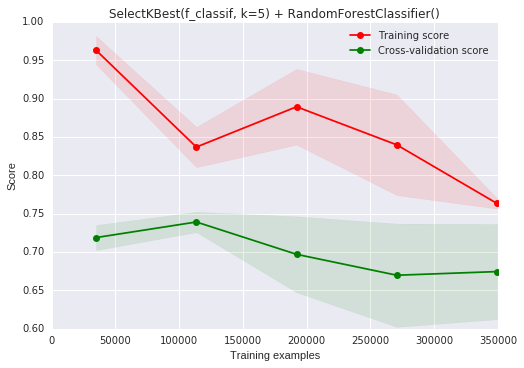

In [281]:
plot_learning_curve(
    Pipeline([("fs", SelectKBest(f_classif, k=5)), 
             ('RandomForest', RandomForestClassifier())]),
    "SelectKBest(f_classif, k=5) + RandomForestClassifier()",
    X,y,
#     train_sizes=np.linspace(.05, 0.2, 5)
)

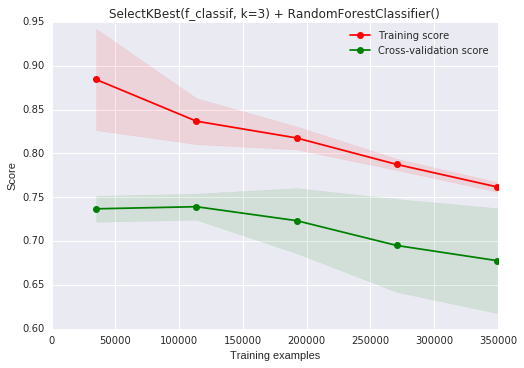

In [258]:
plot_learning_curve(
    Pipeline([("fs", SelectKBest(f_classif, k=3)), 
             ('RandomForest', RandomForestClassifier())]),
    "SelectKBest(f_classif, k=3) + RandomForestClassifier()",
    X,y,
#     train_sizes=np.linspace(.05, 0.2, 5)
)

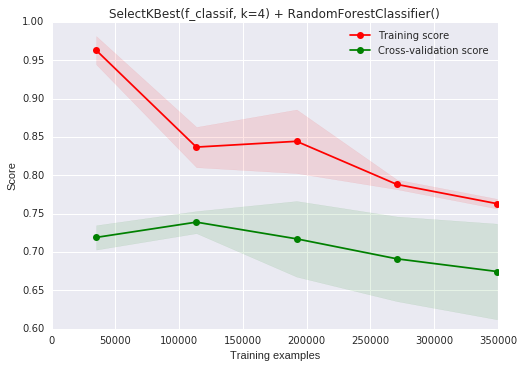

In [259]:
plot_learning_curve(
    Pipeline([("fs", SelectKBest(f_classif, k=4)), 
             ('RandomForest', RandomForestClassifier())]),
    "SelectKBest(f_classif, k=4) + RandomForestClassifier()",
    X,y,
#     train_sizes=np.linspace(.05, 0.2, 5)
)

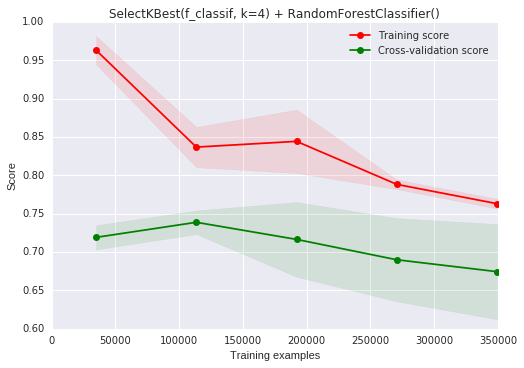

In [274]:
estimator = RandomForestClassifier( n_jobs=-1, criterion='entropy')
clf= plot_learning_curve(
    Pipeline([("fs", SelectKBest(f_classif, k=4)), 
             ('RandomForest', estimator)]),
    "SelectKBest(f_classif, k=4) + RandomForestClassifier()",
    X,y,
#     train_sizes=np.linspace(.05, 0.2, 5)
)

In [267]:
bestK = SelectKBest(f_classif, k=4)

In [268]:
bestK.fit(X, y)

SelectKBest(k=4, score_func=<function f_classif at 0x7ff1c4d58c80>)

In [272]:
for i in zip(bestK.scores_, bestK.pvalues_):
    print i 

(15879.696477513904, 0.0)
(30781.084037566798, 0.0)
(1085.5949364760381, 8.7682436584361209e-238)
(780.33199855647558, 1.4452739381974038e-171)
(105.64218376531228, 8.8904162038174552e-25)
(908.88538172722065, 1.8444493918362935e-199)
(684.00164428729624, 1.1783751037436883e-150)
(466.58704401199452, 2.0081426913008139e-103)
(95.056400878646883, 1.8601742948446553e-22)
(3610.9734879049988, 0.0)
(11733.132274208994, 0.0)
(6935.3852052034399, 0.0)
(437.02142117372659, 5.3751262221167015e-97)
(4805.9869747814073, 0.0)
(8284.7943328540568, 0.0)
(4801.2723213615564, 0.0)
(1612.6235649010941, 0.0)
(0.33208891893006076, 0.56443193530932056)
(1862.9422636639931, 0.0)
(1.719668620896958, 0.18973639596907491)
(2.2519529202496846, 0.13344661952935136)
(77.357577876366406, 1.4314858948712123e-18)
(1496.5540740640847, 0.0)
(4679.3039568121367, 0.0)
(1317.5348399961824, 4.7225827275951448e-288)
(934.59821093198036, 4.8767284422647693e-205)
